# Scanpy tutorial

In [3]:
!pip install scanpy
!pip install decoupler
!pip install leidenalg
!pip install omnipath

  Using cached scanpy-1.10.1-py3-none-any.whl (2.1 MB)
  Using cached legacy_api_wrap-1.4-py3-none-any.whl (15 kB)
  Using cached pynndescent-0.5.12-py3-none-any.whl (56 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached session_info-1.0.0-py3-none-any.whl
  Using cached statsmodels-0.14.2-cp310-cp310-win_amd64.whl (9.8 MB)
  Using cached umap_learn-0.5.6-py3-none-any.whl (85 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import decoupler as dc

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1MZ6HmqiCeN5mJd2cYM498PgnNOV8goQ9'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('GTEX-1HSMQ-5005.h5ad')

In [ ]:
!wget -O GTEX-1HSMQ-5005.h5ad  "https://drive.usercontent.google.com/download?id=1MZ6HmqiCeN5mJd2cYM498PgnNOV8goQ9&export=download&authuser=0&confirm=t&uuid=b3f632b6-8dd3-4cbe-aade-886aad76299c&at=APZUnTV6ape4OEBvDGLvCmNBfgp0%3A1714034617680"

In [3]:
adata = ad.read_h5ad('GTEX-1HSMQ-5005.h5ad')
adata

AnnData object with n_obs × n_vars = 14404 × 17695
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', 'A

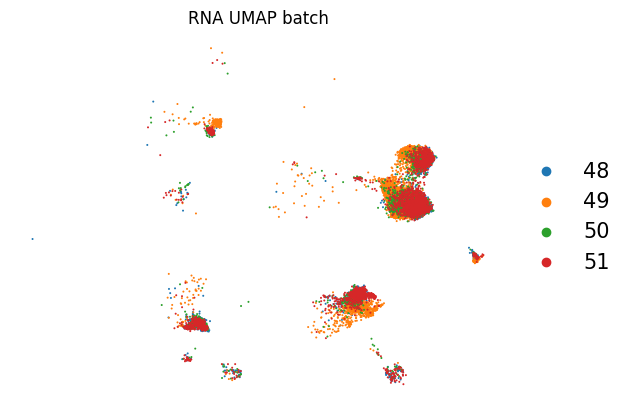

In [4]:
sc.pl.umap(adata, color='batch', title='RNA UMAP batch', frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [ ]:
adata[adata.obs.batch == '49'].obs['Broad cell type (numbers)']

## Slicing one batch

In [6]:
ada = adata

## Filtering and quality control

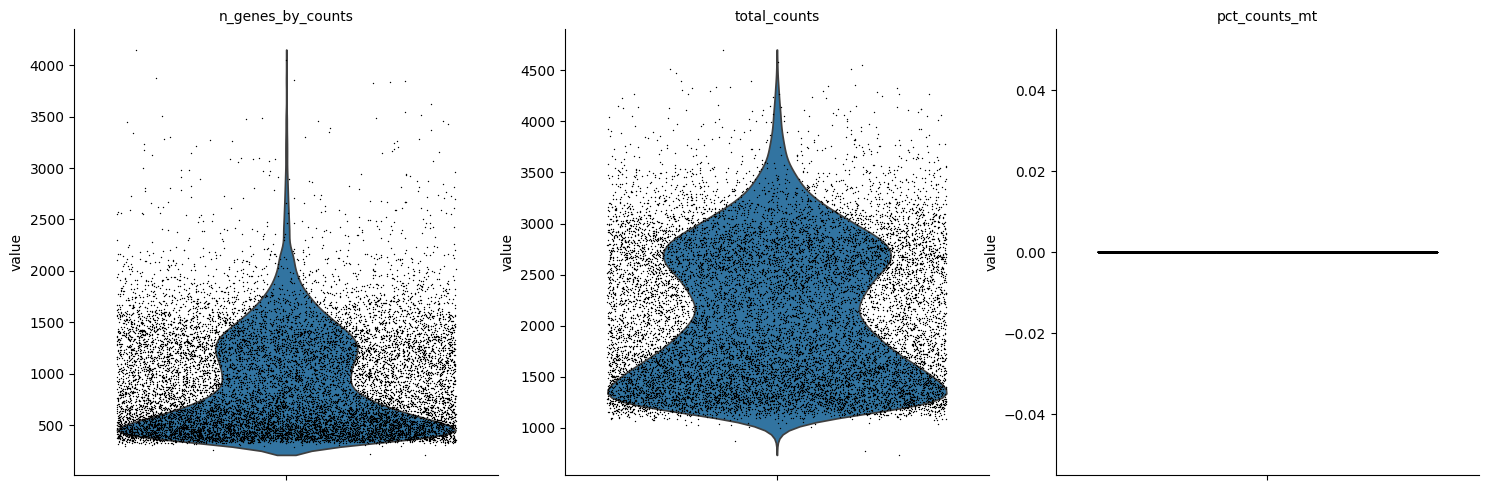

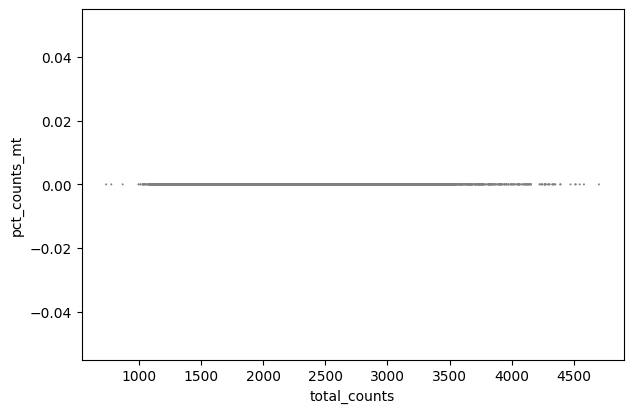

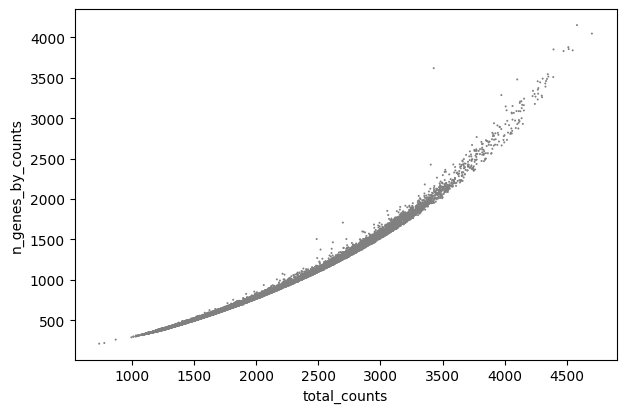

AnnData object with n_obs × n_vars = 14404 × 16803
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', '

In [7]:
sc.pp.filter_cells(ada, min_genes=200)
sc.pp.filter_genes(ada, min_cells=3)

ada.var['mt'] = ada.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(ada, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(ada, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(ada, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(ada, x="total_counts", y="n_genes_by_counts")
ada

In [8]:
ada

AnnData object with n_obs × n_vars = 14404 × 16803
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', '

In [ ]:
# Filter cells following standard QC criteria.
ada = ada[ada.obs.n_genes_by_counts < 2000, :]

## Normalization, scaling, dimensionality reduction and clustering

In [ ]:
# Normalize the data
sc.pp.normalize_total(ada, target_sum=1e4)
sc.pp.log1p(ada)
ada.layers['log_norm'] = ada.X.copy()

In [ ]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(ada, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Regress and scale the data
sc.pp.regress_out(ada, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(ada, max_value=10)

# Generate PCA features
sc.tl.pca(ada, svd_solver='arpack')

#Restore X to be norm counts
dc.swap_layer(ada, 'log_norm', X_layer_key=None, inplace=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(ada, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(ada)

# Run leiden clustering algorithm
sc.tl.leiden(ada)

# Visualize
sc.pl.umap(ada, color='leiden', title='Leiden UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(ada, color='Cell types level 2', title='Ground truth UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)


In [ ]:
sc.tl.leiden(ada, resolution=0.05)
# Visualize
sc.pl.umap(ada, color='leiden', title='Leiden UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(ada, color='Cell types level 2', title='Ground truth UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

## Cell type annotation


In [ ]:
markers = dc.get_resource('PanglaoDB')
markers

In [ ]:
# Filter by canonical_marker and human
markers = markers[markers['human'] & markers['canonical_marker'] & (markers['human_sensitivity'] > 0.5)]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

In [ ]:
dc.run_ora(
    mat=ada,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

In [ ]:
ada.obsm['ora_estimate']

In [ ]:
acts = dc.get_acts(ada, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

In [ ]:
sc.pl.umap(acts, color=['T cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['T cells'], groupby='leiden')

In [ ]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

In [ ]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

In [ ]:
# df2 = dc.rank_sources_groups(acts, groupby='Cell types level 2', reference='rest', method='t-test_overestim_var')
# ctypes_dict2 = df2.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
# ctypes_dict2

In [ ]:
predicted_types = ada.obsm['ora_estimate'].idxmax(axis=1)
predicted_types

In [ ]:
from collections import Counter
Counter(predicted_types)

In [ ]:
ada.obs['Broad cell type (numbers)'].unique()

In [ ]:
from sklearn.metrics.cluster import contingency_matrix
cm = contingency_matrix(ada.obs.loc[:, 'Broad cell type (numbers)'], predicted_types)
# Visualize the confusion matrix using Seaborn
class_labels_y = np.unique(ada.obs.loc[:, 'Broad cell type (numbers)'])
class_labels_x = np.unique(predicted_types)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels_x, yticklabels=class_labels_y)
plt.xlabel("CoDi Predicted Labels")
plt.ylabel("Labels from original paper")
plt.title("Contingency Matrix")
# plt.savefig(out_name, dpi=150, bbox_inches='tight')

## Different parameters and preprocessing

In [ ]:
ada2 = adata[adata.obs.batch == '49'].copy()

sc.pp.filter_cells(ada2, min_genes=200)
sc.pp.filter_genes(ada2, min_cells=3)

# Normalize the data
sc.pp.normalize_total(ada2, target_sum=1e4)
sc.pp.log1p(ada2)

sc.pp.scale(ada2)

# Generate PCA features
sc.tl.pca(ada2, svd_solver='arpack')
# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(ada2, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(ada2)



In [ ]:
# Run leiden clustering algorithm
sc.tl.leiden(ada2, resolution=0.05)

# Visualize
sc.pl.umap(ada2, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
# Visualize
sc.pl.umap(ada2, color='Cell types level 2', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [ ]:
dc.run_ora(
    mat=ada2,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)
acts2 = dc.get_acts(ada2, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v2 = acts2.X.ravel()
max_e2 = np.nanmax(acts_v2[np.isfinite(acts_v2)])
acts2.X[~np.isfinite(acts2.X)] = max_e2

df2 = dc.rank_sources_groups(acts2, groupby='leiden', reference='rest', method='t-test_overestim_var')
ctypes_dict2 = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict2